<a href="https://colab.research.google.com/github/miguelangel18241/Probabilities/blob/main/data_visualization_Chocolate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Run to load and clean the dataset
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


In [3]:
choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')


# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

#choc_data.dtypes

#Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

#@title Cast bean_type to string to remove leading 'u'
## This code converts all the values in that column to string
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
## This code removes the % SYMBOL from every value in the percentage column
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
## Makes the values to tread them as numbers. REMEMBER TO ALWAYS CLEAN THE DATA AS IF IT WAS NOT IN THE FORMAT IT IS.
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')\

# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')





<ipython-input-3-79cf16d0eccf>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('U.K.', 'England')\


In [4]:
def cleanup_spelling_abbrev(text):
  replacements = [
      ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
      ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
      ['Mad,|Mad$', 'Madagascar, '],
      ['PNG', 'Papua New Guinea, '],
      ['Guat,|Guat$', 'Guatemala, '],
      ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
      ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
      ['Nic,|Nic$', 'Nicaragua, '],
      ['Cost Rica', 'Costa Rica'],
      ['Mex,|Mex$', 'Mexico, '],
      ['Jam,|Jam$', 'Jamaica, '],
      ['Haw,|Haw$', 'Hawaii, '],
      ['Gre,|Gre$', 'Grenada, '],
      ['Tri,|Tri$', 'Trinidad, '],
      ['C Am', 'Central America'],
      ['S America', 'South America'],
      [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
      [' Bali', ',Bali']
  ]
  for i,j in replacements:
    text = re.sub(i,j,text)
  return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

## PRACTICE THE APPLICATION OF THE PREVIOUS FUNCTION BY YOURSELF # CHOC_DATA['SPECIFIC_ORIGIN'] = CHOC_DATA['SPECIFIC_ORIGIN'].STR.REPLACE('.', '').APPLY(CLEANUP_SPELLING_ABBREV)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.','').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']), 'bean_type'] = "Criollo, Trinitario"

#Fix chocolate maker names
choc_data.loc[choc_data['maker'] == 'Shattel', 'maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')


# Save the original column names
original_cols = choc_data.columns.values

choc_data.head()


<ipython-input-4-1a4ca71e7f04>:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)
<ipython-input-4-1a4ca71e7f04>:37: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.','').apply(cleanup_spelling_abbrev)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


In [5]:
original_text = "## practice the application of the previous function by yourself # choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)"
uppercase_version = original_text.upper()
print(uppercase_version)

## PRACTICE THE APPLICATION OF THE PREVIOUS FUNCTION BY YOURSELF # CHOC_DATA['SPECIFIC_ORIGIN'] = CHOC_DATA['SPECIFIC_ORIGIN'].STR.REPLACE('.', '').APPLY(CLEANUP_SPELLING_ABBREV)


In [6]:
count = choc_data['bean_type'].unique()
count


array(['Blend', 'Criollo', 'Trinitario', 'Forastero (Arriba)',
       'Forastero', 'Forastero (Nacional)', 'Criollo, Trinitario',
       'Criollo (Porcelana)', 'Trinitario (85% Criollo)',
       'Forastero (Catongo)', 'Forastero (Parazinho)', 'CCN51',
       'Criollo (Ocumare)', 'Nacional', 'Criollo (Ocumare 61)',
       'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)', 'Criollo (Wild)',
       'Beniano', 'Amazon mix', 'Trinitario, Forastero',
       'Forastero (Arriba) ASS', 'Criollo, +', 'Amazon', 'Amazon, ICS',
       'EET', 'Blend-Forastero,Criollo', 'Trinitario (Scavina)',
       'Criollo, Forastero', 'Matina', 'Forastero(Arriba, CCN)',
       'Nacional (Arriba)', 'Forastero (Arriba) ASSS',
       'Forastero, Trinitario', 'Forastero (Amelonado)',
       'Trinitario, Nacional', 'Trinitario (Amelonado)',
       'Trinitario, TCGA', 'Criollo (Amarru)'], dtype=object)

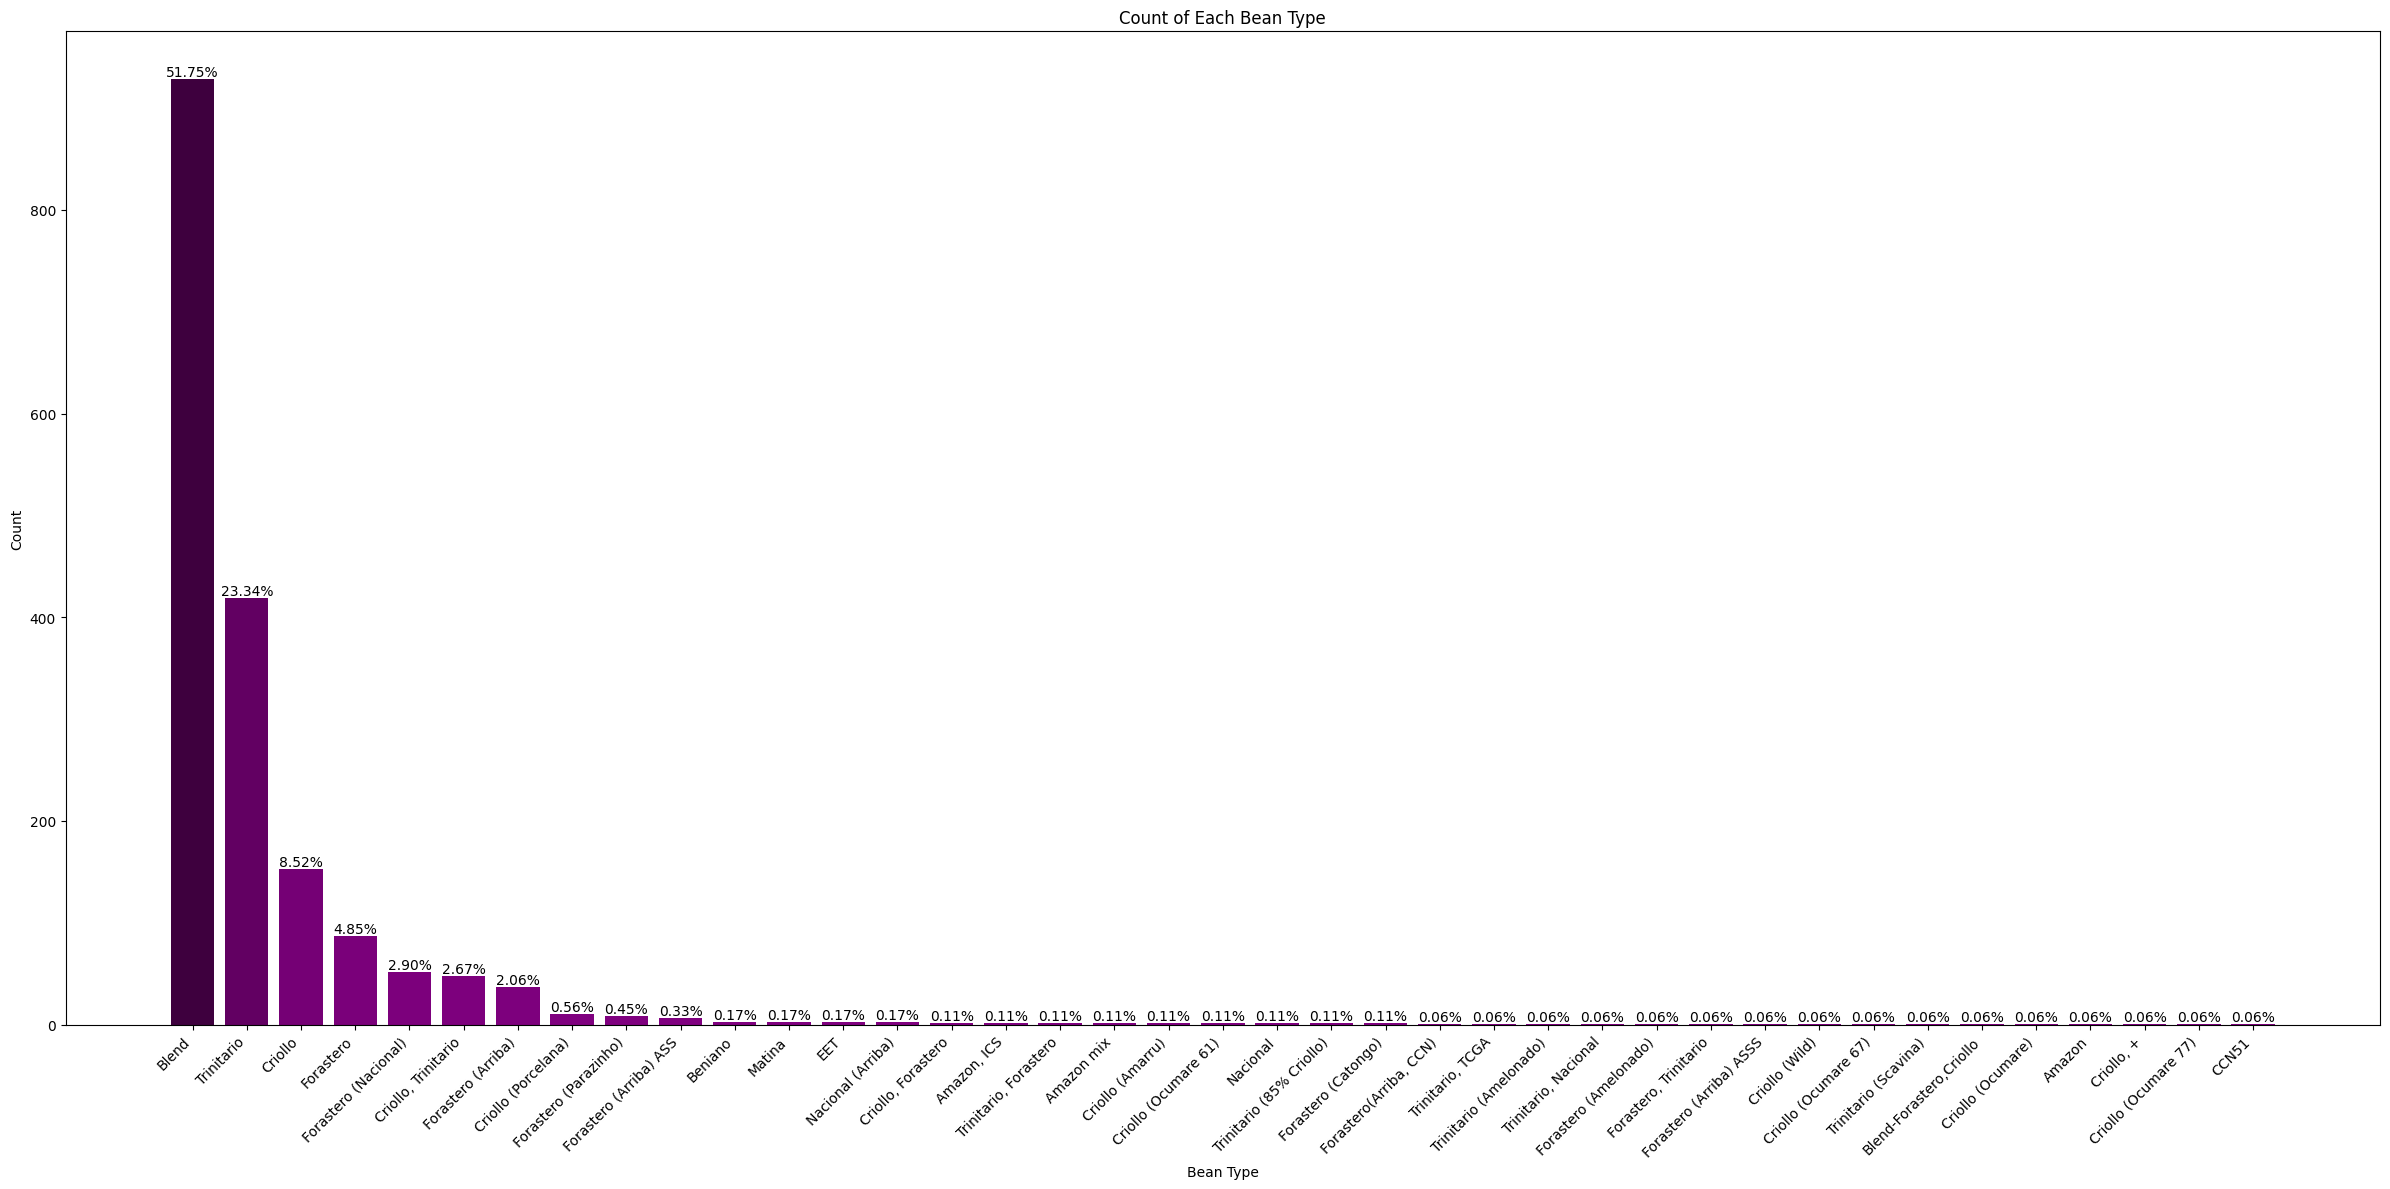

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap from purple to black
colors = [(0.5, 0, 0.5), (0, 0, 0)]  # Purple to black
cmap = LinearSegmentedColormap.from_list('PurpleToBlack', colors)


bean_types_list = []
bean_types_count = []
for bean_types in choc_data['bean_type'].unique():
  bean_types_list.append(bean_types)
  [str(bean_types)]

count_blend = choc_data['bean_type'].value_counts()

bean_types = count_blend.index
counts = count_blend.values

total_count = counts.sum()

# Set the size of the figure
plt.figure(figsize=(24, 12))  # Width: 12 inches, Height: 8 inches
# Plotting
bars = plt.bar(bean_types, counts, color=cmap(counts / total_count), edgecolor='white', linewidth=2.5)  # Increase linewidth for better visibility

# Set the top edge color to transparent
for bar in bars:
    bar.set_edgecolor((1, 1, 1, 0))  # RGBA color with alpha value 0 for transparent

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Bean Type')
plt.ylabel('Count')
plt.title('Count of Each Bean Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# bean_types_list = [str(bean_types)]
# bean_types_list
# for types in choc_data:
#   count = choc_data['bean_type'].count(bean_types_list)
#   bean_types_count.append(count)

# print(bean_types_list)
# print(bean_types_count)
# count = (choc_data['bean_type'] == bean_types_list[])
# count

In [8]:
# Why this? Analyzing the distribution of cocoa percentages
# or its relationship with other factors like rating or
# origin could be another goal.

In [9]:
# The dataset contains review dates,
# allowing for temporal analysis of chocolate production
# trends over time. Analyzing how ratings or other
# factors change over different review years
# could be an objective.

In [10]:
# # choc_data.drop(columns=['review_data', 'reference_number'], inplace=True)
# x = choc_data.columns
# choc_data = choc_data.drop
# x
# #choc_data = choc_data.drop(columns=['review_data', 'reference_number'])
# #This would create a new DataFrame with the specified columns dropped, leaving the original choc_data unchanged unless assigned back to it.

In [11]:
# choc_data['broad_origin'] = choc_data['broad_origin'].fillna("No Country")
# no_broad_origin = choc_data[choc_data['broad_origin'] == "No Country"]
# print(len(no_broad_origin))


In [12]:

# print(type(choc_data))
# print(type(data_2011))
# print(type(avg_rating_by_origin))

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


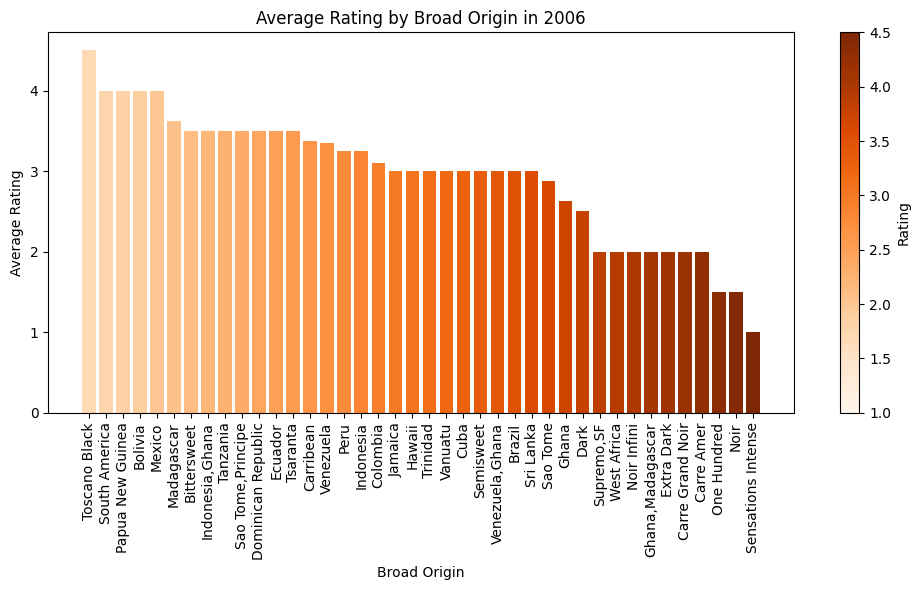

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


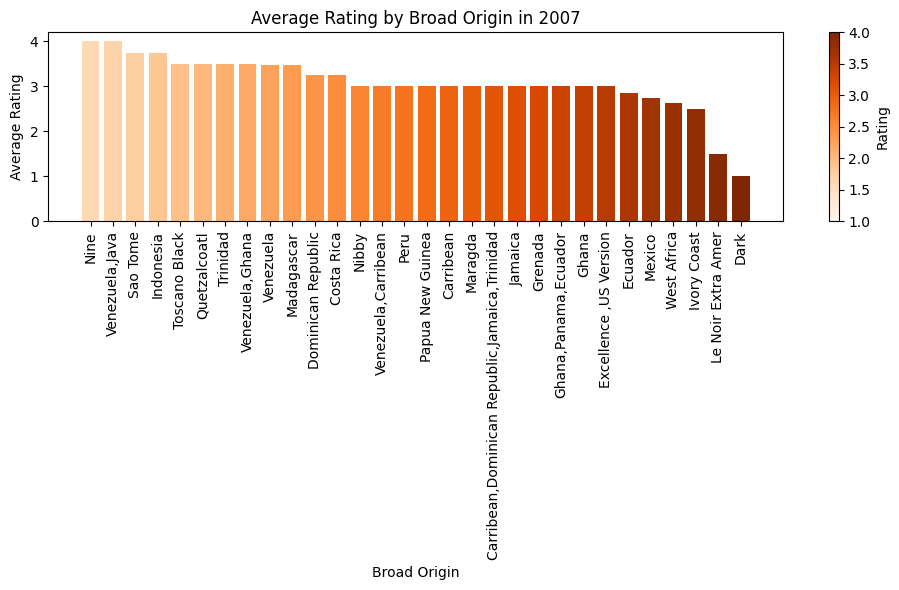

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


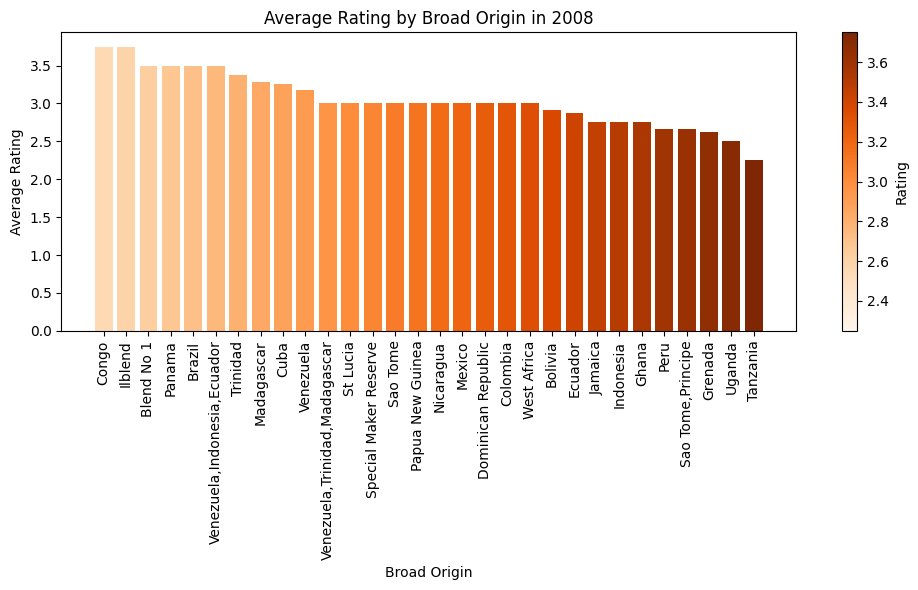

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


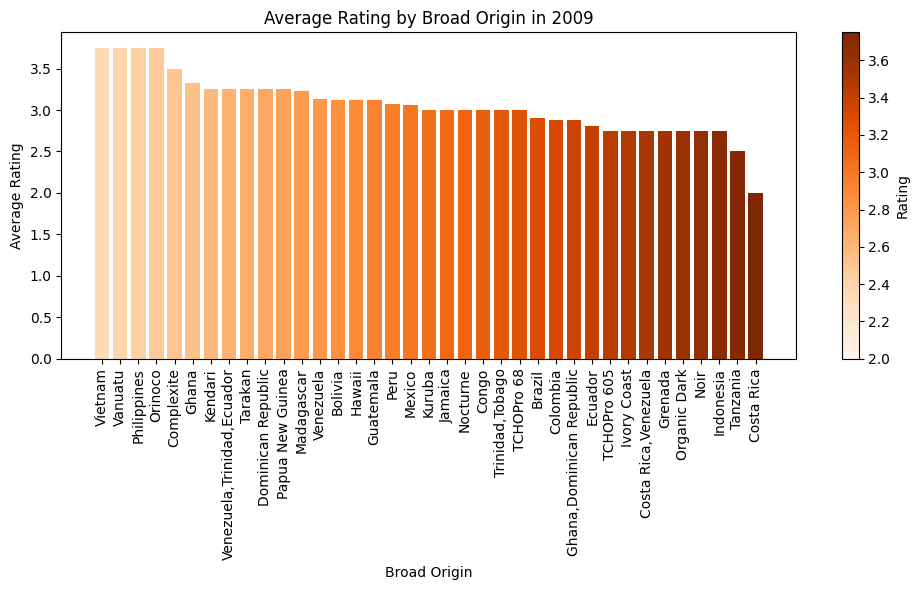

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


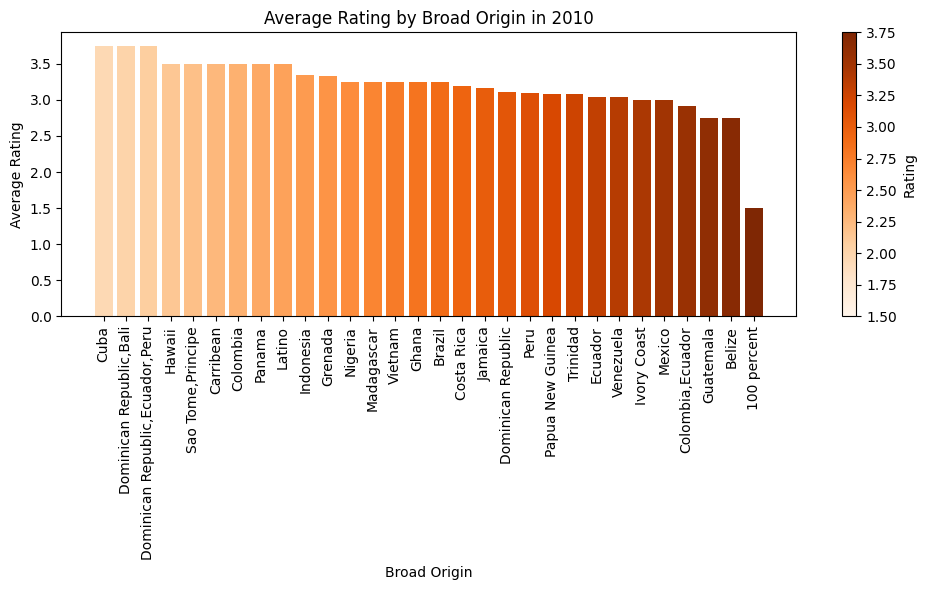

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


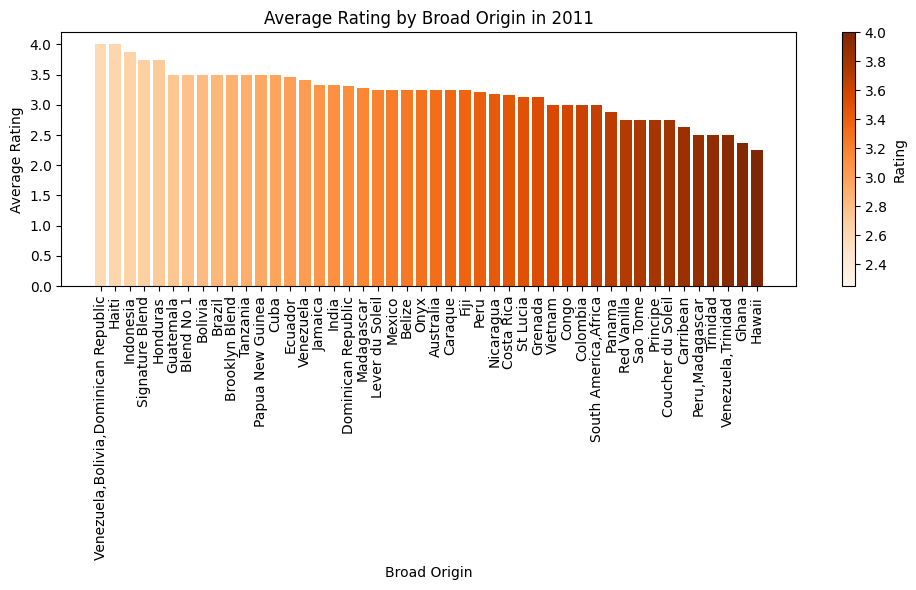

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


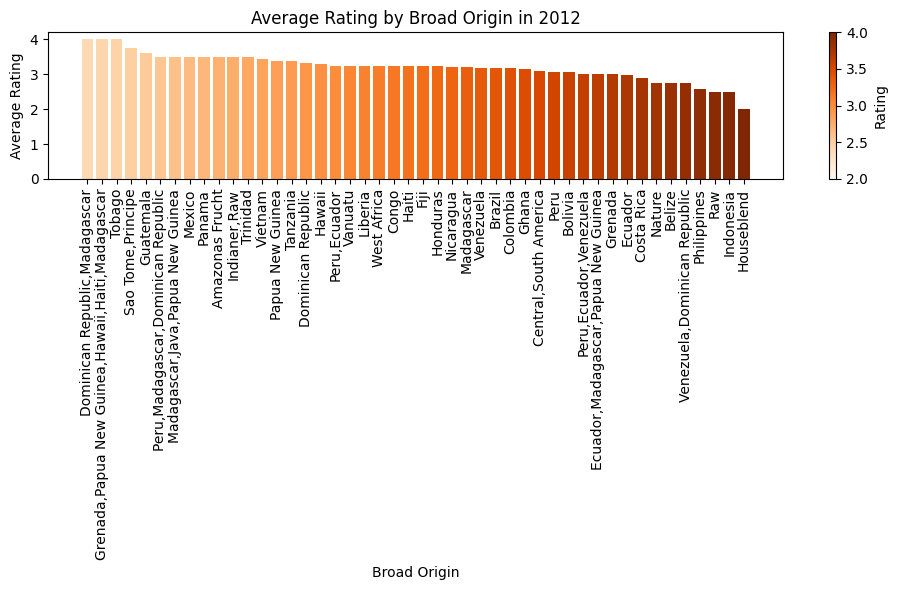

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


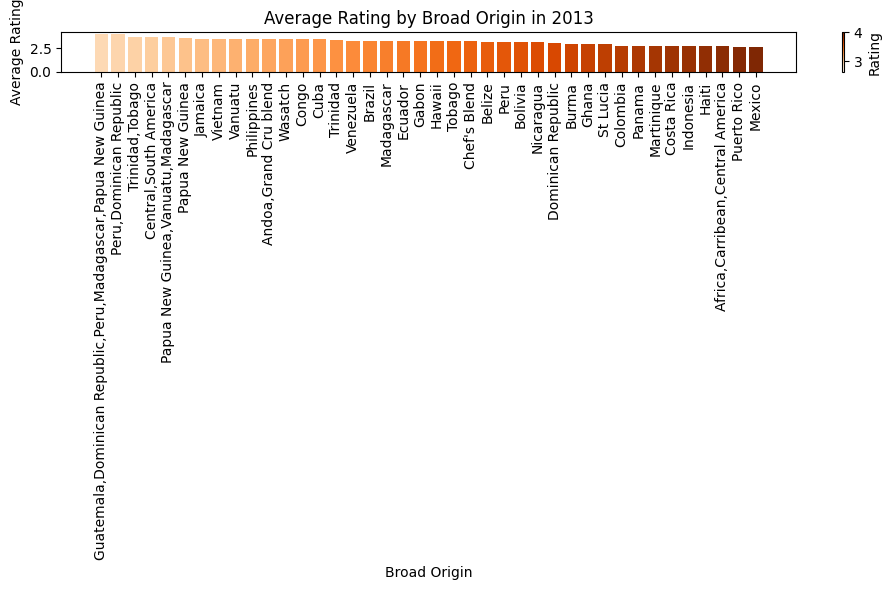

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


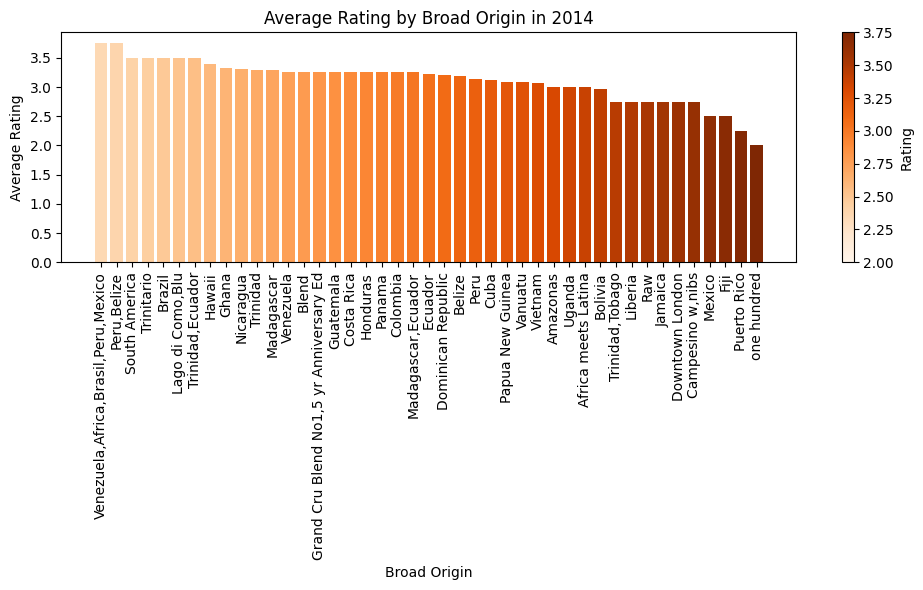

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


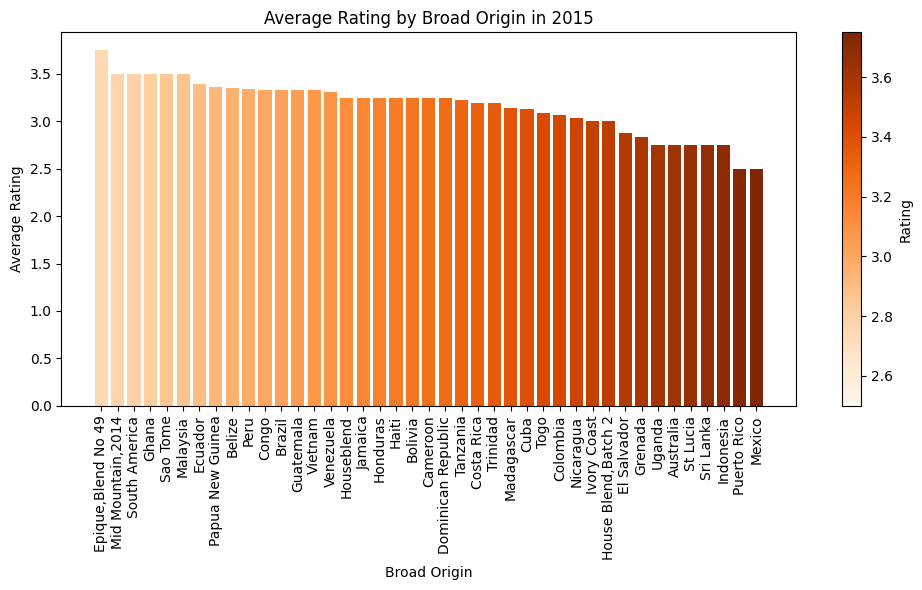

<ipython-input-20-9ece458e25b1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


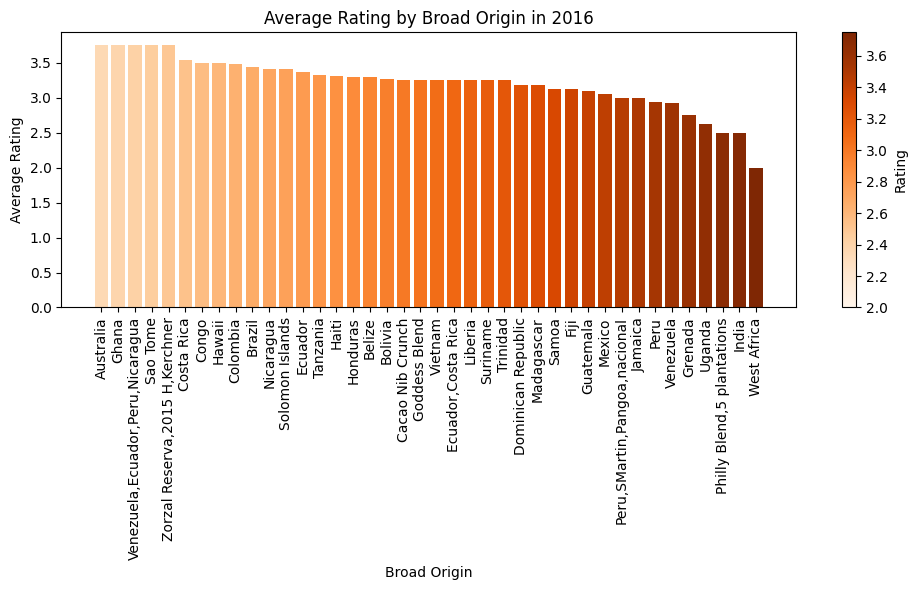

In [20]:
import matplotlib.cm as cm
x = 2011
for i in range(2006,2017):

  data_2011 = choc_data[choc_data['review_date'] == i]
  avg_rating_by_origin = data_2011.groupby('broad_origin')['rating'].mean()

  average_rating_2011 = pd.DataFrame(avg_rating_by_origin)

  average_rating_2011_sorted = average_rating_2011.sort_values(by='rating', ascending=False)

  # Define colormap (e.g., from dark orange to white)
  colors = cm.Oranges(np.linspace(0.2, 1, len(average_rating_2011_sorted)))

  # Plot the average ratings by broad origin with gradient colors
  plt.figure(figsize=(10, 6))
  bars = plt.bar(average_rating_2011_sorted.index, average_rating_2011_sorted['rating'], color=colors)
  plt.xlabel('Broad Origin')
  plt.ylabel('Average Rating')
  plt.title(f'Average Rating by Broad Origin in {i}')
  plt.xticks(rotation=90)
  plt.tight_layout()

  # Add colorbar legend to show the range of colors
  sm = plt.cm.ScalarMappable(cmap=cm.Oranges, norm=plt.Normalize(vmin=average_rating_2011_sorted['rating'].min(), vmax=average_rating_2011_sorted['rating'].max()))
  sm.set_array([])  # Remove array to avoid error
  cbar = plt.colorbar(sm)
  cbar.set_label('Rating')

  plt.show()


In [ ]:
from google.colab import files
count_them = choc_data['broad_origin'].value_counts()

count_them.to_csv('Total_entradas.csv')
files.download('Total_entradas.csv')

